## Introduction

If there are few (typically 2) ways of using the word in a sentence and only one of them is correct, we call it an _alternative problem_, and the word we call _problematic word_. The typical example in English language is whether to write the ending -s to the verb: "I see", but "she sees". In Russian, these alternative problems are much more present and deserve their own codebase.

The approach is to take the correct sentences, replace the problematic words with their counterparts, thus building negative samples. Also, when doing it, we want to balance the sentences by corpus and by length, as these factors often affect the performance. Finally, when we merge the data from different corpora, we want to update `sentence_id`, `word_id` and `paragraph_id`, as those must be unique in the dataset.


## TSA 

TSA is an alternative problem where verbs have similar but different endings in invinitive (ться) and finite form (тся). No all the verbs are like this (e.g. нравится/нравиться, but хочется/хотеться), so first we need to filter the verbs that are _problematic_.

### Creating dictionary


First, let's define the list of corpora we will use in our bundle. Assume we have three corpora: news, publicistics and books.

In [1]:
from tg.grammar_ru import Loc

corpora = [
    Loc.corpus_path/'books.base.zip',
    Loc.corpus_path/'pub.base.zip',
    Loc.corpus_path/'lenta.base.zip',
]

Not every sentence in the corpora contains problematic word, so first we need to detect the sentences that are required in the bundle. For this particular task we will use a dictionary approach: we will scan the corpora and find verbs that are presented there in both -тся and -ться forms.

In [2]:
from yo_fluq_ds import *

good_words = set(FileIO.read_json('files/tsa-dict.json'))
list(good_words)[:5]

['просочится', 'проносится', 'завалиться', 'пристроиться', 'свыкнуться']

### Building negative samples


We need a filter that will select the problematic sentences. We will use the filter that selects only the sentences with the words from the given dictionary. To view its functionality, we will create a demonstration dataframe:


In [3]:
from tg.grammar_ru import Separator
from tg.projects.alternative import DictionaryFilterer

df = Separator.separate_string('Мне нравится борщ. Он вкусный.')
tsa_filter = DictionaryFilterer(good_words)
tsa_filter.filter(df)

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Мне,ru,3,False
1,1,0,1,0,1,нравится,ru,8,True
2,2,0,2,0,0,борщ,ru,4,False
3,3,0,3,0,1,.,punct,1,False


As we can see, only the first sentence is included. Also, there is `is_target` column that indicates if the word is problematic.

 We need to build negative samples: the original sentence where the right word was replace with erroneous.

In [4]:
from tg.projects.alternative import EndingNegativeSampler

df = Separator.separate_string('Мне нравится борщ. И не нравится рассольник.')
df = tsa_filter.filter(df)
tsa_sampler = EndingNegativeSampler('тся','ться')
tsa_sampler.build_negative_sample_from_positive(df)

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Мне,ru,3,False
1,1,0,1,0,1,нравиться,ru,8,True
2,2,0,2,0,0,борщ,ru,4,False
3,3,0,3,0,1,.,punct,1,False
4,4,1,0,0,1,И,ru,1,False
5,5,1,1,0,1,не,ru,2,False
6,6,1,2,0,1,нравиться,ru,8,True
7,7,1,3,0,0,рассольник,ru,10,False
8,8,1,4,0,0,.,punct,1,False


But what if we have two problematic words in the same sentence?

In [5]:
df = Separator.separate_string('Мне нравится борщ, а рассольник не нравится.')
df = tsa_filter.filter(df)
tsa_sampler.build_negative_sample_from_positive(df)

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Мне,ru,3,False
1,1,0,1,0,1,нравиться,ru,8,True
2,2,0,2,0,0,борщ,ru,4,False
3,3,0,3,0,1,",",punct,1,False
4,4,0,4,0,1,а,ru,1,False
5,5,0,5,0,1,рассольник,ru,10,False
6,6,0,6,0,1,не,ru,2,False
7,7,0,7,0,0,нравиться,ru,8,True
8,8,0,8,0,0,.,punct,1,False


So, if two or more problematic words are contained in the sentence, in the resulting dataset all of them will be either correct or erroneous. This is imperfect, as it does not reflect the way we make errors in the texts. So, another method is introduced to correct that:

In [6]:
df = Separator.separate_string('Мне нравится борщ, а рассольник не нравится.')
df = tsa_filter.filter(df)
pd.concat(tsa_sampler.build_all_negative_samples_from_positive(df))

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Мне,ru,3,False
1,1,0,1,0,1,нравиться,ru,8,True
2,2,0,2,0,0,борщ,ru,4,False
3,3,0,3,0,1,",",punct,1,False
4,4,0,4,0,1,а,ru,1,False
5,5,0,5,0,1,рассольник,ru,10,False
6,6,0,6,0,1,не,ru,2,False
7,7,0,7,0,0,нравится,ru,8,False
8,8,0,8,0,0,.,punct,1,False
0,0,0,0,0,1,Мне,ru,3,False


## Balancing dataset


We want an equal representation of the sentences of different lengths, as well as sentences from different corpora. To do this, we will scan the corpora again, consider only the sentences that have a problematic word, and then compute the length of each such sentence.

In [7]:
from tg.grammar_ru.corpus import BucketBalancer, CorpusReader
from pathlib import Path

buckets_path = Path('files/tsa-buckets.parquet')

if not buckets_path.is_file():
    en = CorpusReader.read_frames_from_several_corpora(corpora).feed(fluq.with_progress_bar()).select(tsa_filter.filter)
    buckets_df = BucketBalancer.collect_buckets(en)
    buckets_df.to_parquet(buckets_path)
else:
    buckets_df = pd.read_parquet(buckets_path)


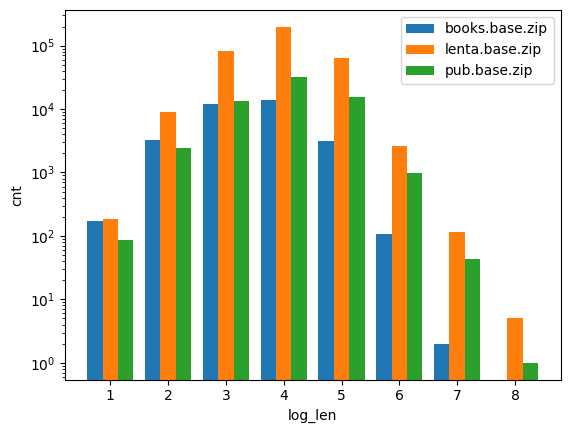

In [8]:
from tg.common.analysis import grbar_plot

ax = grbar_plot(
    buckets_df.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.set_yscale('log')
ax.legend()


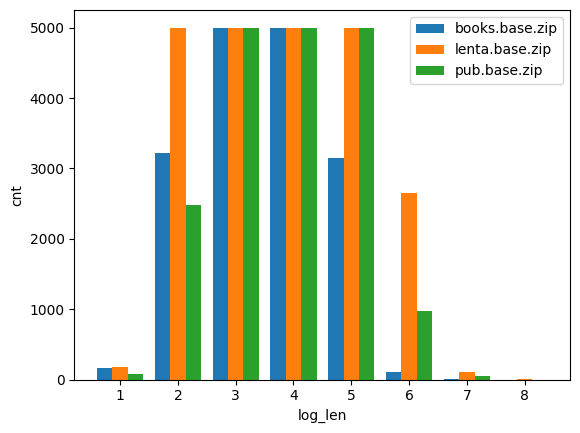

In [9]:
import numpy as np
take_df = buckets_df
take_df['random'] = np.random.rand(take_df.shape[0])
take_df = take_df.feed(fluq.add_ordering_column(['corpus_id','log_len'],'random'))
take_df = take_df.loc[take_df.order<5000]


ax = grbar_plot(
    take_df.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()


Let's convert `take_df` into simpler format for `BucketBalancer`, and create a balancer:

In [10]:
tsa_balancer = BucketBalancer(BucketBalancer.buckets_statistics_to_dict(take_df))
str(tsa_balancer.buckets)[:100]

"{'books.base.zip': {13434883, 9699332, 10551300, 29655046, 25460744, 33751050, 4915211, 19660812, 74"

At this point, we are ready to perform transfusion. Transfusion is an operation that reads the corpora, samples the sentences and creates a new corpus with these selected sentences. Along the way it also correct all the ids, thus making sure the merged corpus is consistant.


In [11]:
from tg.projects.alternative import AlternativeTaskTransfuseSelector
from tg.grammar_ru.corpus import CorpusBuilder
from tg.common import Logger

Logger.disable()

selector = AlternativeTaskTransfuseSelector(
    tsa_balancer,
    tsa_filter,
    tsa_sampler
)

tsa_transfused = Loc.temp_path/'demos/bundle/tsa.transfused.zip'


CorpusBuilder.transfuse_corpus(
    sources = corpora,
    destination = tsa_transfused,
    selector = selector,
    words_limit=10000,
    words_per_frame = 3000,
    overwrite = True
)

In [12]:
from tg.grammar_ru import CorpusReader

CorpusReader(tsa_transfused).get_toc()

,filename,timestamp,part_index,token_count,character_count,ordinal,max_id
file_id,,,,,,,
5a2498bd-3826-4fa3-9ae9-866b2ce90cb5,,2023-12-13 12:42:51.438617,0,2977,13676,0,3165
7213e4ca-dd19-4c77-8cb1-6e97d02936a8,,2023-12-13 12:42:52.156891,1,2979,13110,1,6364
a4675a3c-0cce-41d5-aaf7-8164d694690f,,2023-12-13 12:42:52.655505,2,2945,13460,2,9474
c52be85e-6434-4b89-9c8e-328ed55ca36b,,2023-12-13 12:42:57.301285,3,1436,6277,3,11031


In [13]:
CorpusReader(tsa_transfused).get_frames().first().head()

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,original_word_id,original_sentence_id,original_paragraph_id,updated,file_id,corpus_id,is_target,label,original_corpus
0,0,0,0,0,1,Чем,ru,3,10784,10716,10711,False,5a2498bd-3826-4fa3-9ae9-866b2ce90cb5,tsa.transfused.zip,False,0,books.base.zip
1,1,0,1,0,1,больше,ru,6,10785,10716,10711,False,5a2498bd-3826-4fa3-9ae9-866b2ce90cb5,tsa.transfused.zip,False,0,books.base.zip
2,2,0,2,0,1,он,ru,2,10786,10716,10711,False,5a2498bd-3826-4fa3-9ae9-866b2ce90cb5,tsa.transfused.zip,False,0,books.base.zip
3,3,0,3,0,1,старался,ru,8,10787,10716,10711,False,5a2498bd-3826-4fa3-9ae9-866b2ce90cb5,tsa.transfused.zip,False,0,books.base.zip
4,4,0,4,0,1,сосредоточиться,ru,15,10788,10716,10711,False,5a2498bd-3826-4fa3-9ae9-866b2ce90cb5,tsa.transfused.zip,True,0,books.base.zip


The next step is to enrich the corpus with features. This can also be done with `CorpusBuilder`:

In [14]:
from tg.grammar_ru.features import PyMorphyFeaturizer, SlovnetFeaturizer

tsa_featurized = Loc.temp_path/'demos/bundle/tsa.featurized.zip'

CorpusBuilder.featurize_corpus(
    tsa_transfused,
    tsa_featurized,
    [PyMorphyFeaturizer(), SlovnetFeaturizer()]
)

Now we have all the information in the corpus format. We need to assemble this in bundle format: concatenate all the separate frames from `src`, `pymorphy` and other frames:

In [15]:
tsa_bundle = Loc.temp_path/'demos/bundle/bundle'
CorpusBuilder.assemble(
    tsa_featurized,
    tsa_bundle
)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

And finally, we need to create an index frame. This is usually just a subset of `src` frame:

In [16]:
index_frame = pd.read_parquet(tsa_bundle/'src.parquet')
index_frame = index_frame.loc[index_frame.is_target][['word_id','sentence_id','label']].reset_index(drop=True)
index_frame.index.name = 'sample_id'
index_frame.to_parquet(tsa_bundle/'index.parquet')
index_frame.head()

,word_id,sentence_id,label
sample_id,,,
0,4,0,0
1,38,1,0
2,42,2,0
3,62,3,0
4,101,4,0


## CHTOBY task

CHTOBY is an alternative problem of "что бы" vs "чтобы". There is a technical problem when building negative samples, as the word count is different when one option is replaced by another. Therefore, other implementations of filterer and sampler are needed:

In [17]:
from tg.projects.alternative import WordSequenceFilterer

df = Separator.separate_string('Что бы поделать, чтобы не скучать')
chtoby_filter = WordSequenceFilterer([['чтобы'], ['что','бы']])

chtoby_filter.filter(df)

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Что,ru,3,True
1,1,0,1,0,1,бы,ru,2,False
2,2,0,2,0,0,поделать,ru,8,False
3,3,0,3,0,1,",",punct,1,False
4,4,0,4,0,1,чтобы,ru,5,True
5,5,0,5,0,1,не,ru,2,False
6,6,0,6,0,0,скучать,ru,7,False


In [18]:
from tg.projects.alternative import WordPairsNegativeSampler
df = Separator.separate_string('Что бы поделать, чтобы не скучать')
df = chtoby_filter.filter(df)

chtoby_sampler = WordPairsNegativeSampler([('чтобы', 'что бы'), ('Чтобы', 'Что бы')])

chtoby_sampler.build_negative_sample_from_positive(df)

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Чтобы,ru,23,True
1,1,0,1,0,0,поделать,ru,8,False
2,2,0,2,0,1,",",punct,1,False
3,3,0,3,0,1,что,ru,21,True
4,4,0,4,0,1,бы,ru,2,False
5,5,0,5,0,1,не,ru,2,False
6,6,0,6,0,0,скучать,ru,7,False


In [19]:
pd.concat(chtoby_sampler.build_all_negative_samples_from_positive(df))

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Чтобы,ru,23,True
1,1,0,1,0,0,поделать,ru,8,False
2,2,0,2,0,1,",",punct,1,False
3,3,0,3,0,1,чтобы,ru,5,False
4,4,0,4,0,1,не,ru,2,False
5,5,0,5,0,0,скучать,ru,7,False
0,0,0,0,0,1,Что,ru,3,False
1,1,0,1,0,1,бы,ru,2,False
2,2,0,2,0,0,поделать,ru,8,False
3,3,0,3,0,1,",",punct,1,False
